In [1]:
import tensorflow as tf
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import sys
sys.path.append('../..')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import SuperTrend
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np

In [8]:

class super_reversion_strat():
    def __init__(
        self,
        df_list,
        oldest_pair,
        parameters_obj
    ):
        self.df_list = df_list
        self.oldest_pair = oldest_pair
        self.parameters_obj = parameters_obj
        
    def populate_indicators(self, show_log=False):
        # -- Clear dataset --
        for pair in self.df_list:
            df = self.df_list[pair]
            params = self.parameters_obj[pair]
            df.drop(columns=df.columns.difference(['open','high','low','close','volume']), inplace=True)
            
            # -- Populate indicators --
            super_trend = SuperTrend(
                df['high'], 
                df['low'], 
                df['close'], 
                params["st_short_atr_window"], 
                params["st_short_atr_multiplier"]
            )
            
            df['super_trend_direction'] = super_trend.super_trend_direction()
            df['ema_short'] = ta.trend.ema_indicator(close=df['close'], window=params["short_ema_window"])
            df['ema_long'] = ta.trend.ema_indicator(close=df['close'], window=params["long_ema_window"])
            
            df = get_n_columns(df, ["super_trend_direction", "ema_short", "ema_long"], 1)
            
            self.df_list[pair] = df
            # -- Log --
            if(show_log):
                print(self.df_list[self.oldest_pair])
                
        return self.df_list[self.oldest_pair]
    
    def populate_buy_sell(self, show_log=False): 
        data_open_long = []
        data_close_long = []

        for pair in self.df_list:
            params = self.parameters_obj[pair]
            df = self.df_list[pair]
            # -- Initiate populate --
            df["open_long_limit"] = False
            df["close_long_limit"] = False
            df["pair"] = pair
            df["null"] = np.nan
            
            # -- Populate open long limit --
            df.loc[
                (df['n1_ema_short'] >= df['n1_ema_long']) 
                & (df['n1_super_trend_direction'] == True) 
                & (df['n1_ema_short'] > df['low']) 
                , "open_long_limit"
            ] = True
            
            # -- Populate close long limit --
            df.loc[
                ((df['n1_ema_short'] <= df['n1_ema_long'])
                | (df['n1_super_trend_direction'] == False))
                & (df['n1_ema_short'] < df['high'])
                , "close_long_limit"
            ] = True
                
            # -- Populate pair list per date (do not touch)--
            data_open_long.append(
                df.loc[
                (df['open_long_limit']  == True) 
                ]['pair']
            )
            data_close_long.append(
                df.loc[
                (df['close_long_limit']  == True) 
                ]['pair']
            )

        data_open_long.append(self.df_list[self.oldest_pair]['null'])
        data_close_long.append(self.df_list[self.oldest_pair]['null'])
        df_open_long = pd.concat(data_open_long, axis=1)
        df_open_long['combined']= df_open_long.values.tolist()
        df_open_long['combined'] = [[i for i in j if i == i] for j in list(df_open_long['combined'])]
        df_close_long = pd.concat(data_close_long, axis=1)
        df_close_long['combined']= df_close_long.values.tolist()
        df_close_long['combined'] = [[i for i in j if i == i] for j in list(df_close_long['combined'])]
        self.open_long_obj = df_open_long['combined']
        self.close_long_obj = df_close_long['combined']
        
        # -- Log --
        if(show_log):
            print("Open LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["open_long"]==True]))
            print("Close LONG length on oldest pair :",len(self.df_list[self.oldest_pair].loc[self.df_list[self.oldest_pair]["close_long"]==True]))
        
        return self.df_list[self.oldest_pair]
    
    def run_backtest(self, initial_wallet=1000, return_type="metrics"):
        df_ini = self.df_list[self.oldest_pair][:]
        wallet = initial_wallet
        usd_remaining = initial_wallet
        usd_pct_remaining = 1
        maker_fee = 0.001
        taker_fee = 0.001
        trades = []
        days = []
        current_day = 0
        previous_day = 0
        current_positions = {}
        
        for index, row in df_ini.iterrows():
            # -- Add daily report --
            current_day = index.day
            if previous_day != current_day:
                temp_wallet = wallet
                for pos in current_positions:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['close']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * taker_fee
                    temp_wallet += close_size - current_positions[pos]['size'] - fee
                    
                days.append({
                    "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
                    "wallet":temp_wallet,
                    "price":row['close']
                })
            previous_day = current_day 
            
            # Sell
            close_long_row = self.close_long_obj.loc[index]
            if len(current_positions) > 0:
                position_to_close = set(current_positions).intersection(set(close_long_row))
                for pos in position_to_close:
                    actual_row = self.df_list[pos].loc[index]
                    close_price = actual_row['n1_ema_short']
                    trade_result = (close_price - current_positions[pos]['price']) / current_positions[pos]['price']
                    close_size = current_positions[pos]['size'] + current_positions[pos]['size']  * trade_result
                    fee = close_size * maker_fee
                    wallet += close_size - current_positions[pos]['size'] - fee
                    usd_remaining += close_size - fee
                    usd_pct_remaining += self.parameters_obj[pos]['wallet_exposure']
                    trades.append({
                        "pair": pos,
                        "open_date": current_positions[pos]['date'],
                        "close_date": index,
                        "position": current_positions[pos]['side'],
                        "open_reason": current_positions[pos]['reason'],
                        "close_reason": "Market",
                        "open_price": current_positions[pos]['price'],
                        "close_price": close_price,
                        "open_fee": current_positions[pos]['fee'],
                        "close_fee": fee,
                        "open_trade_size":current_positions[pos]['size'],
                        "close_trade_size":close_size,
                        "wallet": wallet,
                        "usd_remaining": usd_remaining
                    })
                    del current_positions[pos]   
                    
            # Buy
            open_long_row = self.open_long_obj.loc[index]
            if len(open_long_row) > 0:
                for pos in open_long_row:
                    if pos not in current_positions:
                        actual_row = self.df_list[pos].loc[index]
                        open_price = actual_row['n1_ema_short']
                        pos_size = usd_remaining * (self.parameters_obj[pos]['wallet_exposure'] / usd_pct_remaining)
                        usd_pct_remaining -= self.parameters_obj[pos]['wallet_exposure']
                        fee = pos_size * maker_fee
                        pos_size -= fee
                        wallet -= fee
                        usd_remaining -= pos_size+fee
                        current_positions[pos] = {
                            "size": pos_size,
                            "date": index,
                            "price": open_price,
                            "fee":fee,
                            "reason": "Market",
                            "side": "LONG"
                        }
        df_days = pd.DataFrame(days)
        df_days['day'] = pd.to_datetime(df_days['day'])
        df_days = df_days.set_index(df_days['day'])

        df_trades = pd.DataFrame(trades)
        df_trades['open_date'] = pd.to_datetime(df_trades['open_date'])
        df_trades = df_trades.set_index(df_trades['open_date'])   
        
        if return_type == "metrics":
            return get_metrics(df_trades, df_days) | {
                "wallet": wallet,
                "trades": df_trades,
                "days": df_days
            }  
        else:
            return True

In [76]:
params_coin = {
    "BTC/USDT": {
        "wallet_exposure": 0.01,
        "st_short_atr_window": 10,
        "st_short_atr_multiplier": 3,
        "short_ema_window": 9,
        "long_ema_window": 100
    },
    "ETH/USDT": {
        "wallet_exposure": 0.01,
        "st_short_atr_window": 10,
        "st_short_atr_multiplier": 3,
        "short_ema_window": 9,
        "long_ema_window": 100
    },
    "LTC/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 10,
        "st_short_atr_multiplier": 3,
        "short_ema_window": 5,
        "long_ema_window": 100
    },
    "SOL/USDT": {
        "wallet_exposure": 0.02,
        "st_short_atr_window": 10,
        "st_short_atr_multiplier": 3,
        "short_ema_window": 9,
        "long_ema_window": 100
    },
    "LUNA/USDT": {
        "wallet_exposure": 0.9,
        "st_short_atr_window": 7,
        "st_short_atr_multiplier": 3,
        "short_ema_window": 10,
        "long_ema_window": 200
    },
}

pair_list = list(params_coin.keys())
tf = '1m'
oldest_pair = "BTC/USDT"

df_list = {}
for pair in pair_list:
    df = get_historical_from_db(ccxt.binance(), pair, tf, path="../../database/")
    df_list[pair] = df.loc[:]

print("Data load 100%")
df_list[oldest_pair]

Data load 100%


,open,high,low,close,volume
date,,,,,
2020-07-01 00:00:00,9138.08,9138.16,9126.66,9126.75,29.777507
2020-07-01 00:01:00,9126.75,9129.91,9116.83,9118.63,64.406983
2020-07-01 00:02:00,9117.93,9119.68,9100.00,9104.43,210.822875
2020-07-01 00:03:00,9104.44,9115.31,9104.28,9115.02,38.691824
2020-07-01 00:04:00,9114.62,9118.62,9112.90,9117.23,22.128671
...,...,...,...,...,...
2022-05-19 19:32:00,30036.14,30038.13,30012.29,30016.99,27.600390
2022-05-19 19:33:00,30017.00,30023.37,30000.00,30006.87,29.007710
2022-05-19 19:34:00,30006.87,30006.87,29990.00,29994.83,18.718720


In [85]:
df_list['LUNA/USDT']=df_list['LUNA/USDT']['2022-03-01' :'2022-05-01']
df_list['ETH/USDT']=df_list['LUNA/USDT']['2022-04-01' :'2022-05-01']
df_list['LTC/USDT']=df_list['LTC/USDT']['2022-03-01' :'2022-05-01']
df_list['SOL/USDT']=df_list['SOL/USDT']['2022-04-29' :'2022-04-30']
df_list['BTC/USDT']=df_list['BTC/USDT']['2022-03-01' :'2022-04-15']

In [86]:
df_list['LUNA/USDT']

,open,high,low,close,volume,super_trend_direction,ema_short,ema_long,n1_super_trend_direction,n1_ema_short,n1_ema_long,open_long_limit,close_long_limit,pair,null
date,,,,,,,,,,,,,,,
2022-03-01 00:00:00,91.35,91.41,91.10,91.18,10020.54,True,NaN,NaN,NaN,NaN,NaN,False,False,LUNA/USDT,NaN
2022-03-01 00:01:00,91.21,91.89,91.12,91.62,26252.17,True,NaN,NaN,True,NaN,NaN,False,False,LUNA/USDT,NaN
2022-03-01 00:02:00,91.62,92.22,91.58,92.14,18467.58,True,NaN,NaN,True,NaN,NaN,False,False,LUNA/USDT,NaN
2022-03-01 00:03:00,92.17,92.17,91.38,91.38,19700.63,True,NaN,NaN,True,NaN,NaN,False,False,LUNA/USDT,NaN
2022-03-01 00:04:00,91.37,91.82,91.33,91.68,12164.88,True,91.576790,NaN,True,NaN,NaN,False,False,LUNA/USDT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01 23:55:00,82.22,82.30,82.22,82.25,813.82,False,82.209583,81.124606,False,82.189375,81.120096,False,True,LUNA/USDT,NaN
2022-05-01 23:56:00,82.26,82.33,82.25,82.27,582.91,False,82.229722,81.129179,False,82.209583,81.124606,False,True,LUNA/USDT,NaN
2022-05-01 23:57:00,82.28,82.34,82.10,82.11,1921.99,False,82.189815,81.133094,False,82.229722,81.129179,False,True,LUNA/USDT,NaN


Period: [2022-03-01 00:00:00] -> [2022-04-15 00:00:00]
Initial wallet: 1000.0 $
Trades on 4 pairs

--- General Information ---
Final wallet: 665.14 $
Performance vs US dollar: -33.49 %
Sharpe Ratio: -6.16
Worst Drawdown T|D: -37.27% | -33.93%
Buy and hold performance: -7.59 %
Performance vs buy and hold: -28.02 %
Total trades on the period: 3003
Global Win rate: 27.14 %
Average Profit: -0.03 %

----- Pair Result -----
-----------------------------------------------------------------------------------------------
Trades      Pair     Sum-result     Mean-trade    Worst-trade     Best-trade       Win-rate
-----------------------------------------------------------------------------------------------
1018    BTC/USDT       -21.27 %        -0.02 %        -2.09 %         5.68 %        28.98 %
938     LTC/USDT        -8.56 %        -0.01 %        -4.01 %         3.08 %        26.12 %
754    LUNA/USDT       -45.98 %        -0.06 %         -2.7 %         8.57 %         25.6 %
293     ETH/USDT  

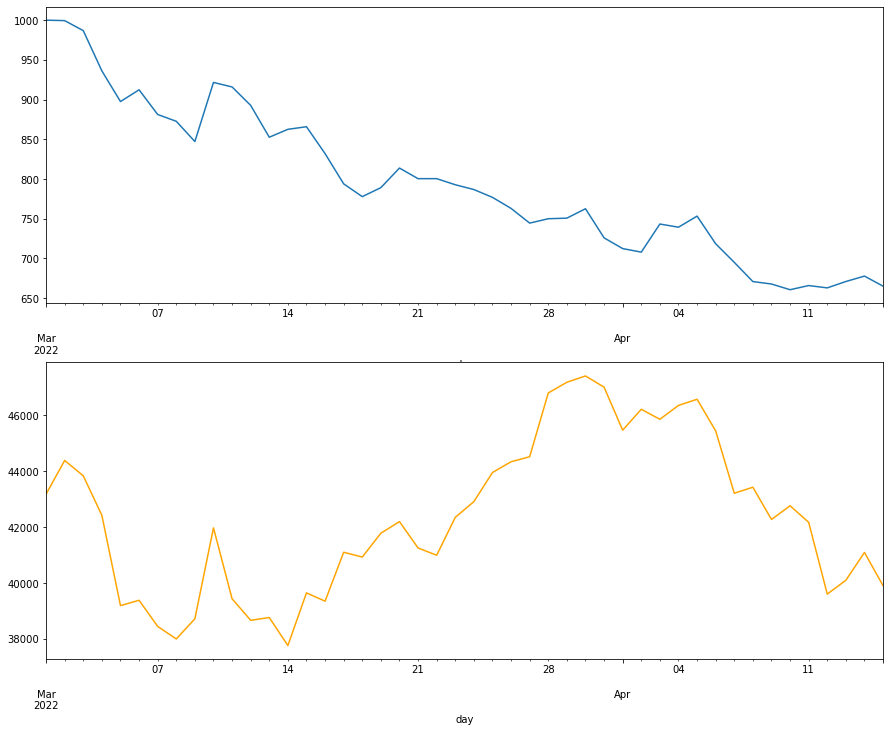

In [87]:
strat = super_reversion_strat(
    df_list=df_list,
    oldest_pair=oldest_pair,
    parameters_obj=params_coin
)

strat.populate_indicators()
strat.populate_buy_sell()
bt_result = strat.run_backtest(initial_wallet=1000, return_type="metrics")

df_trades, df_days = basic_multi_asset_backtest(trades=bt_result['trades'], days = bt_result['days'])
plot_wallet_vs_asset(df_days=df_days)

In [84]:
bt_result

{'sharpe_ratio': -6.155286939035511,
 'win_rate': 0.2713952713952714,
 'avg_profit': -0.00032818073485772536,
 'total_trades': 3003,
 'max_drawdown': -33.92961428225897,
 'wallet': 644.9847818056649,
 'trades':                          pair           open_date          close_date  \
 open_date                                                               
 2022-03-01 01:45:00  BTC/USDT 2022-03-01 01:45:00 2022-03-01 02:01:00   
 2022-03-01 03:54:00  BTC/USDT 2022-03-01 03:54:00 2022-03-01 03:57:00   
 2022-03-01 04:02:00  LTC/USDT 2022-03-01 04:02:00 2022-03-01 04:12:00   
 2022-03-01 04:50:00  LTC/USDT 2022-03-01 04:50:00 2022-03-01 05:11:00   
 2022-03-01 04:02:00  BTC/USDT 2022-03-01 04:02:00 2022-03-01 05:13:00   
 ...                       ...                 ...                 ...   
 2022-04-15 22:14:00  BTC/USDT 2022-04-15 22:14:00 2022-04-15 22:19:00   
 2022-04-15 22:27:00  BTC/USDT 2022-04-15 22:27:00 2022-04-15 22:52:00   
 2022-04-15 23:00:00  BTC/USDT 2022-04-15 23:00:00

----- 2017 Cumulative Performances: 45.32% -----


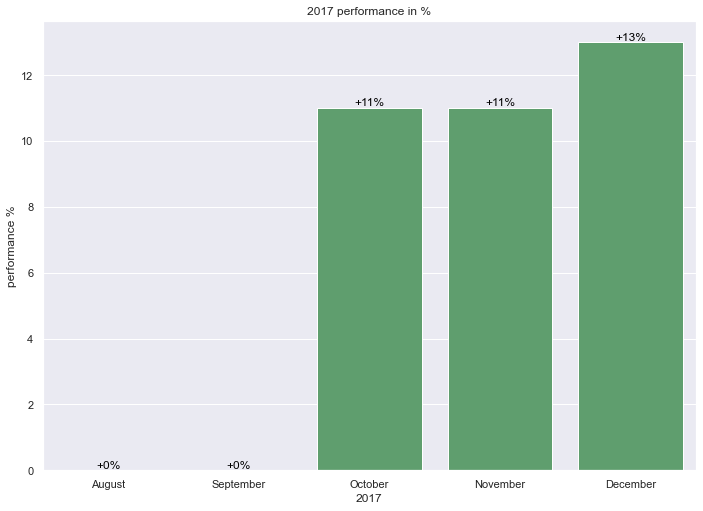

----- 2018 Cumulative Performances: 14.55% -----


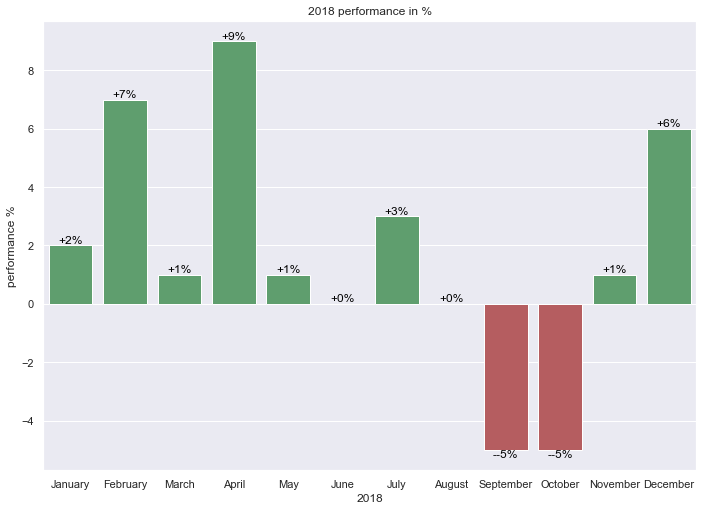

----- 2019 Cumulative Performances: 65.79% -----


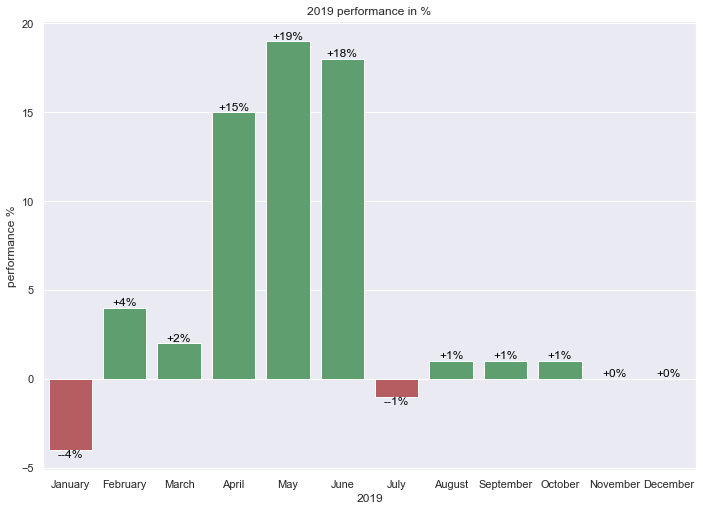

----- 2020 Cumulative Performances: 112.95% -----


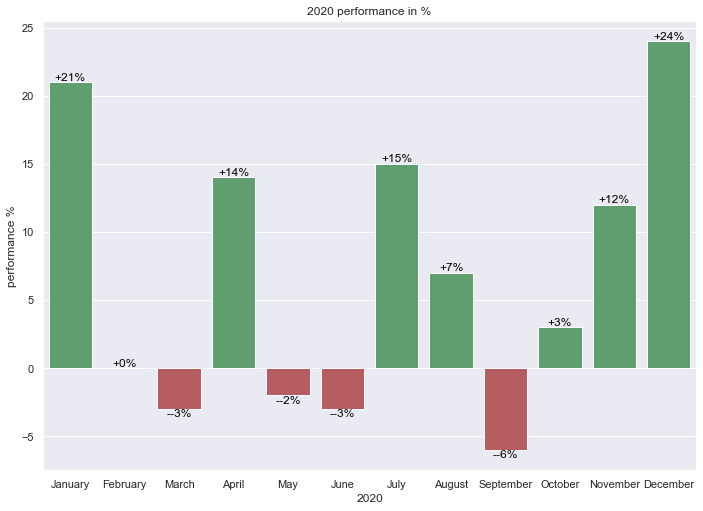

----- 2021 Cumulative Performances: 1064.77% -----


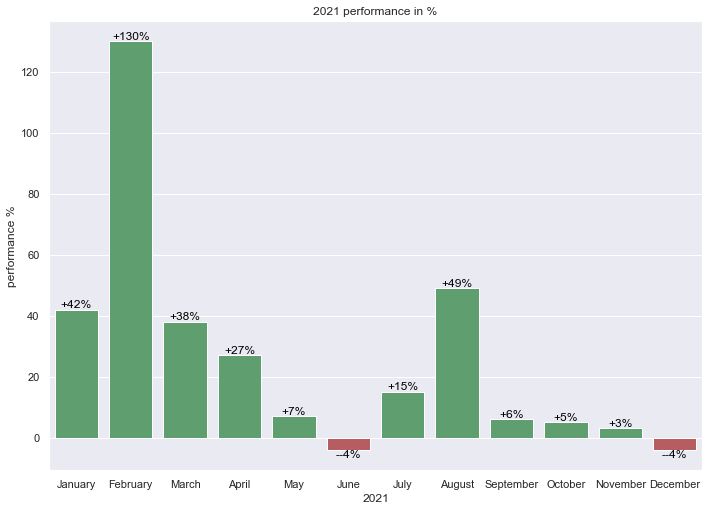

----- 2022 Cumulative Performances: -4.17% -----


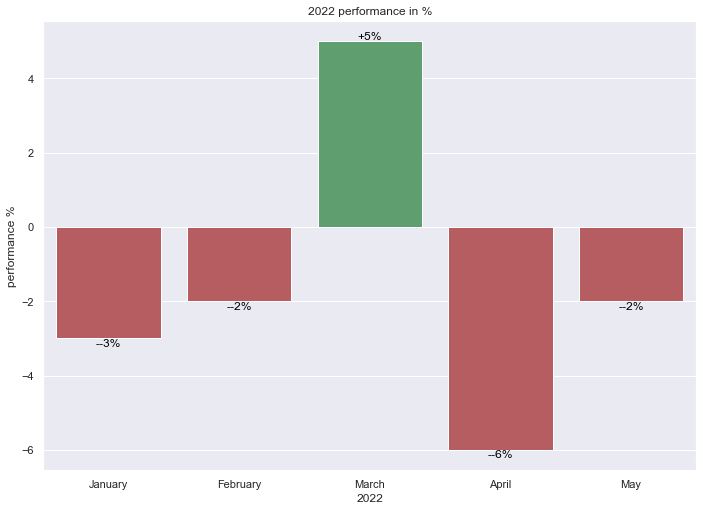

In [ ]:
plot_bar_by_month(df_days=df_days)